In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
weights_path = "/content/drive/MyDrive/Myositis/vgg_binary.h5"
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

IMG_SIZE = (224, 224, 3)

def build_vgg(model_type="VGG16"):


    base = VGG16(include_top=False, weights='imagenet', input_shape=IMG_SIZE)
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512,  activation='relu')(x)
    x = Dense(256,  activation='relu')(x)
    out = Dense(2, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=out)
    for layer in model.layers:
        layer.trainable = True
    model.compile(optimizer=Adam(learning_rate=2e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def build_vggm(model_type="VGG16"):


    base = VGG16(include_top=False, weights='imagenet', input_shape=IMG_SIZE)
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512,  activation='relu')(x)
    x = Dense(256,  activation='relu')(x)
    out = Dense(4, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=out)
    for layer in model.layers:
        layer.trainable = True
    model.compile(optimizer=Adam(learning_rate=2e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [5]:
model = build_vgg(VGG16)
model.load_weights(weights_path)
print("Loaded weights:", weights_path)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loaded weights: /content/drive/MyDrive/Myositis/vgg_binary.h5


Probs: [9.9987197e-01 1.2803590e-04] Pred: Disease


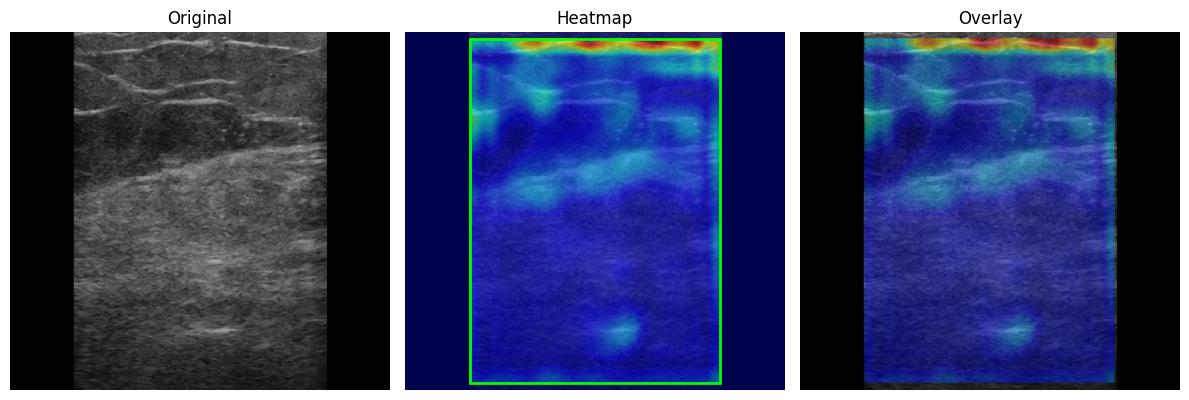

In [6]:
#This one for Binary
import numpy as np, cv2, tensorflow as tf, matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as kimage

TARGET_LAYER = "block4_conv3"
USE_VGG_PREPROC = False
CLASSNAMES = ["Disease","Normal"]

def _preprocess_01(x):
    if USE_VGG_PREPROC:
        from tensorflow.keras.applications.vgg16 import preprocess_input
        return preprocess_input(x.copy())
    return x/255.0

def _overlay(base_uint8, cam01, alpha=0.35):
    cam8 = np.uint8(255*cam01)
    heat = cv2.applyColorMap(cam8, cv2.COLORMAP_JET)[:, :, ::-1]
    return np.uint8(np.clip(alpha*heat + (1-alpha)*base_uint8, 0, 255))

def _gradcam_on_224(model, img224, layer_name, class_idx=None):
    x = tf.convert_to_tensor(img224[None,...], tf.float32)
    conv = model.get_layer(layer_name).output
    gm = tf.keras.Model([model.input],[conv, model.output])
    with tf.GradientTape() as t:
        conv_out, preds = gm(x, training=False)
        if class_idx is None:
            class_idx = int(tf.argmax(preds[0]))
        score = preds[:, class_idx]
    grads = t.gradient(score, conv_out)
    grads = tf.nn.relu(grads)
    w = tf.reduce_mean(grads, axis=(1,2))
    cam = tf.reduce_sum(w[:,None,None,:]*conv_out, axis=-1)[0]
    cam = tf.nn.relu(cam); cam = cam/(tf.reduce_max(cam)+1e-8)
    cam = tf.image.resize(cam[...,None], (224,224)).numpy()[...,0]
    return cam, preds.numpy()[0]


def cam_overlay_only_in_roi(model, image_path, roi_frac, method="gradcam", layer_name=TARGET_LAYER,
                            crop_border=True, alpha=0.35):

    # 1) Load full image for display
    img = kimage.load_img(image_path); x_full = kimage.img_to_array(img).astype("float32")
    if crop_border:
        H,W = x_full.shape[:2]
        y0b, y1b = int(0.05*H), int(0.95*H)
        x_full = x_full[y0b:y1b, :, :]                 # remove overlays
    H,W = x_full.shape[:2]

    # 2) Compute ROI box in pixels (after border-crop)
    y0 = int(np.clip(roi_frac[0]*H, 0, H-1))
    y1 = int(np.clip(roi_frac[1]*H, 0, H))
    x0 = int(np.clip(roi_frac[2]*W, 0, W-1))
    x1 = int(np.clip(roi_frac[3]*W, 0, W))
    if y1<=y0 or x1<=x0:
        raise ValueError("Invalid ROI; check (y0,y1,x0,x1) fractions.")

    # 3) Build model input from ROI only
    roi_rgb = x_full[y0:y1, x0:x1, :]
    roi224  = cv2.resize(roi_rgb, (224,224), interpolation=cv2.INTER_LINEAR)
    roi224p = _preprocess_01(roi224)

    # 4) Pick class, run CAM on the ROI input
    preds = model.predict(roi224p[None,...], verbose=0)[0]
    class_idx = int(np.argmax(preds))
    if method == "gradcam":
        cam224, _ = _gradcam_on_224(model, roi224p, layer_name, class_idx)
    else:
        # Grad-CAM++ (quick impl using 3rd-order grads)
        x = tf.convert_to_tensor(roi224p[None,...], tf.float32)
        conv = model.get_layer(layer_name).output
        gm = tf.keras.Model([model.input],[conv, model.output])
        with tf.GradientTape() as t1:
            with tf.GradientTape() as t2:
                with tf.GradientTape() as t3:
                    conv_out, pr = gm(x, training=False)
                    score = pr[:, class_idx]
                g = t3.gradient(score, conv_out)
            g2 = t2.gradient(g, conv_out)
        g3 = t1.gradient(g2, conv_out)
        eps=1e-8
        num=g2
        den=2.0*g2 + tf.reduce_sum(conv_out*g3, axis=(1,2), keepdims=True) + eps
        a = tf.nn.relu(num/den)
        w = tf.reduce_sum(a*tf.nn.relu(g), axis=(1,2))
        cam = tf.reduce_sum(w[:,None,None,:]*conv_out, axis=-1)[0]
        cam = tf.nn.relu(cam); cam = cam/(tf.reduce_max(cam)+1e-8)
        cam224 = tf.image.resize(cam[...,None], (224,224)).numpy()[...,0]

    # 5) Paste ROI heatmap back to full canvas (only inside ROI)
    cam_roi = cv2.resize(cam224, (x1-x0, y1-y0), interpolation=cv2.INTER_LINEAR)  # 0..1
    heat_full = np.zeros((H,W), dtype=np.float32)
    heat_full[y0:y1, x0:x1] = cam_roi

    # 6) Build overlay only in ROI
    base_uint8 = np.uint8(np.clip(x_full, 0, 255))
    overlay = base_uint8.copy()
    roi_overlay = _overlay(base_uint8[y0:y1, x0:x1], cam_roi, alpha=alpha)
    overlay[y0:y1, x0:x1] = roi_overlay

    # also return probabilities for reference
    return overlay, heat_full, preds, class_idx, (y0,y1,x0,x1), base_uint8

# USE
image_path = "/content/drive/MyDrive/Myositis/images/images/1044.PNG"   # change
#roi = (0.02, 0.98, 0.01, 0.99)  # (y0,y1,x0,x1) FRACTIONS
roi = (0.02, 0.98, 0.17, 0.83)
ov, heat, probs, cls, (y0,y1,x0,x1), base = cam_overlay_only_in_roi(
    model, image_path, roi_frac=roi, method="gradcam", layer_name=TARGET_LAYER, alpha=0.45
)

print("Probs:", probs, "Pred:", CLASSNAMES[cls])
plt.figure(figsize=(12,5))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(base.astype(np.uint8)); plt.axis('off')
plt.subplot(1,3,2); plt.title("Heatmap");
plt.imshow(np.uint8(base));
rect = plt.Rectangle((x0,y0), x1-x0, y1-y0, fill=False, edgecolor='lime', linewidth=2)
plt.gca().add_patch(rect)
plt.imshow(heat, cmap='jet', alpha=0.6); plt.axis('off')
plt.subplot(1,3,3); plt.title("Overlay"); plt.imshow(ov); plt.axis('off')
plt.tight_layout(); plt.show()

In [7]:
weights_path2 = "/content/drive/MyDrive/Myositis/vgg_multi.h5"
model = build_vggm(VGG16)
model.load_weights(weights_path2)
print("Loaded weights:", weights_path)

Loaded weights: /content/drive/MyDrive/Myositis/vgg_binary.h5


Probs: [8.4227580e-01 1.5772420e-01 7.8791640e-09 2.7278007e-09] Pred class idx: 0 Name: IBM


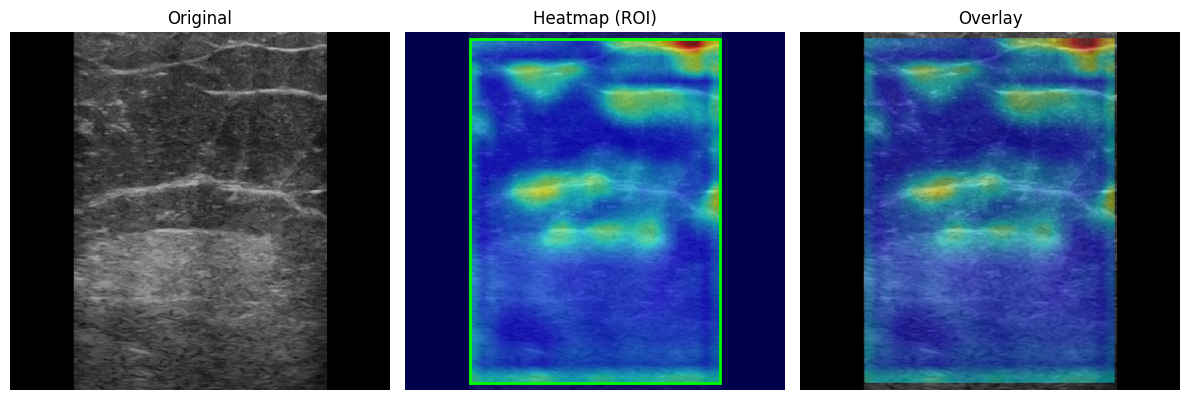

In [8]:
#This one for Multiclass
import numpy as np, cv2, tensorflow as tf, matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as kimage


TARGET_LAYER   = "block4_conv3"
USE_VGG_PREPROC = False
CLASSNAMES     = ["IBM","PM","DM","Normal"]
INPUT_SIZE     = 224

def _preprocess_01(x):
    if USE_VGG_PREPROC:
        from tensorflow.keras.applications.vgg16 import preprocess_input
        return preprocess_input(x.copy())
    return x / 255.0

def _overlay(base_uint8, cam01, alpha=0.35):
    cam8 = np.uint8(255 * np.clip(cam01, 0, 1))
    heat = cv2.applyColorMap(cam8, cv2.COLORMAP_JET)[:, :, ::-1]  # BGR->RGB
    return np.uint8(np.clip(alpha * heat + (1 - alpha) * base_uint8, 0, 255))

def _gradcam_on_224(model, img224, layer_name, class_idx=None):
    x = tf.convert_to_tensor(img224[None, ...], tf.float32)
    conv = model.get_layer(layer_name).output
    gm = tf.keras.Model([model.input], [conv, model.output])
    with tf.GradientTape() as t:
        conv_out, preds = gm(x, training=False)
        # Determine class index robustly: sigmoid vs softmax
        if class_idx is None:
            if preds.shape[-1] == 1:
                # binary sigmoid: decide 0/1 via threshold 0.5
                class_idx = 1 if preds[0, 0] >= 0.5 else 0
            else:
                class_idx = int(tf.argmax(preds[0]))
        score = preds[:, class_idx] if preds.shape[-1] != 1 else preds[:, 0]  # if sigmoid, score is single logit/prob
    grads = t.gradient(score, conv_out)
    grads = tf.nn.relu(grads)
    w = tf.reduce_mean(grads, axis=(1, 2))
    cam = tf.reduce_sum(w[:, None, None, :] * conv_out, axis=-1)[0]
    cam = tf.nn.relu(cam)
    cam = cam / (tf.reduce_max(cam) + 1e-8)
    cam = tf.image.resize(cam[..., None], (INPUT_SIZE, INPUT_SIZE)).numpy()[..., 0]
    return cam, preds.numpy()[0]

def cam_overlay_only_in_roi(model, image_path, roi_frac, method="gradcam", layer_name=TARGET_LAYER,
                            crop_border=True, alpha=0.35, force_class_idx=None, input_channels=3):
    """
    roi_frac = (y0,y1,x0,x1) fractions on image after optional border crop.
    force_class_idx: set an int to visualize a specific class (useful for multiclass).
    input_channels: 1 or 3 depending on model. If 1, image will be converted to grayscale.
    """
    # 1) Load full image
    img = kimage.load_img(image_path)
    x_full = kimage.img_to_array(img).astype("float32")  # H,W,3
    if crop_border:
        H0, W0 = x_full.shape[:2]
        y0b, y1b = int(0.05 * H0), int(0.95 * H0)
        x_full = x_full[y0b:y1b, :, :]   # remove overlays
    H, W = x_full.shape[:2]

    # 2) ROI in pixels
    y0 = int(np.clip(roi_frac[0] * H, 0, H - 1))
    y1 = int(np.clip(roi_frac[1] * H, 0, H))
    x0 = int(np.clip(roi_frac[2] * W, 0, W - 1))
    x1 = int(np.clip(roi_frac[3] * W, 0, W))
    if y1 <= y0 or x1 <= x0:
        raise ValueError("Invalid ROI fractions")

    # 3) Extract ROI and prepare input to model
    roi_rgb = x_full[y0:y1, x0:x1, :].astype("float32")
    # If model expects single channel, convert (and keep dims consistent)
    if input_channels == 1:
        roi_in = cv2.cvtColor(np.uint8(np.clip(roi_rgb, 0, 255)), cv2.COLOR_RGB2GRAY).astype("float32")
        roi_in = roi_in[..., None]  # H,W,1
        roi_resized = cv2.resize(roi_in, (INPUT_SIZE, INPUT_SIZE), interpolation=cv2.INTER_LINEAR)
    else:
        roi_resized = cv2.resize(roi_rgb, (INPUT_SIZE, INPUT_SIZE), interpolation=cv2.INTER_LINEAR)

    roi_p = _preprocess_01(roi_resized)

    # 4) Predict and compute CAM
    preds = model.predict(np.expand_dims(roi_p, 0), verbose=0)[0]
    # Determine class index
    if force_class_idx is not None:
        class_idx = int(force_class_idx)
    else:
        if preds.ndim == 0:
            # single scalar -> sigmoid binary, convert to 0/1
            class_idx = 1 if float(preds) >= 0.5 else 0
        elif preds.size == 1:
            class_idx = 1 if float(preds[0]) >= 0.5 else 0
        else:
            class_idx = int(np.argmax(preds))

    if method == "gradcam":
        cam224, _ = _gradcam_on_224(model, roi_p, layer_name, class_idx)
    else:
        # fallback to gradcam++ — use your previous implementation (kept concise here)
        x = tf.convert_to_tensor(np.expand_dims(roi_p, 0), tf.float32)
        conv = model.get_layer(layer_name).output
        gm = tf.keras.Model([model.input], [conv, model.output])
        with tf.GradientTape() as t1:
            with tf.GradientTape() as t2:
                with tf.GradientTape() as t3:
                    conv_out, pr = gm(x, training=False)
                    score = pr[:, class_idx] if pr.shape[-1] != 1 else pr[:, 0]
                g = t3.gradient(score, conv_out)
            g2 = t2.gradient(g, conv_out)
        g3 = t1.gradient(g2, conv_out)
        eps = 1e-8
        num = g2
        den = 2.0 * g2 + tf.reduce_sum(conv_out * g3, axis=(1, 2), keepdims=True) + eps
        a = tf.nn.relu(num / den)
        w = tf.reduce_sum(a * tf.nn.relu(g), axis=(1, 2))
        cam = tf.reduce_sum(w[:, None, None, :] * conv_out, axis=-1)[0]
        cam = tf.nn.relu(cam)
        cam224 = cam / (tf.reduce_max(cam) + 1e-8)
        cam224 = tf.image.resize(cam224[..., None], (INPUT_SIZE, INPUT_SIZE)).numpy()[..., 0]

    # 5) Paste heatmap back
    cam_roi = cv2.resize(cam224, (x1 - x0, y1 - y0), interpolation=cv2.INTER_LINEAR)  # 0..1
    heat_full = np.zeros((H, W), dtype=np.float32)
    heat_full[y0:y1, x0:x1] = cam_roi

    # 6) produce overlay only inside ROI
    base_uint8 = np.uint8(np.clip(x_full, 0, 255))
    overlay = base_uint8.copy()
    roi_overlay = _overlay(base_uint8[y0:y1, x0:x1], cam_roi, alpha=alpha)
    overlay[y0:y1, x0:x1] = roi_overlay

    return overlay, heat_full, preds, class_idx, (y0, y1, x0, x1), base_uint8

#Use
image_path = "/content/drive/MyDrive/Myositis/images/images/1047.PNG"
#roi = (0.02, 0.98, 0.01, 0.99)
roi = (0.02, 0.98, 0.17, 0.83)
ov, heat, probs, cls, (y0, y1, x0, x1), base = cam_overlay_only_in_roi(
    model, image_path, roi_frac=roi, method="gradcam", layer_name=TARGET_LAYER, alpha=0.45,
    force_class_idx=None, input_channels=3
)

print("Probs:", probs, "Pred class idx:", cls, "Name:", CLASSNAMES[cls] if cls < len(CLASSNAMES) else cls)
plt.figure(figsize=(12,5))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(base.astype(np.uint8)); plt.axis('off')
plt.subplot(1,3,2); plt.title("Heatmap (ROI)"); plt.imshow(np.uint8(base)); rect = plt.Rectangle((x0,y0), x1-x0, y1-y0, fill=False, edgecolor='lime', linewidth=2); plt.gca().add_patch(rect); plt.imshow(heat, cmap='jet', alpha=0.6); plt.axis('off')
plt.subplot(1,3,3); plt.title("Overlay"); plt.imshow(ov); plt.axis('off')
plt.tight_layout(); plt.show()